# Wrangle And Analyze Data

**Author:** Ken Norton (ken@kennethnorton.com)

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Wrangle-And-Analyze-Data" data-toc-modified-id="Wrangle-And-Analyze-Data-1">Wrangle And Analyze Data</a></span><ul class="toc-item"><li><span><a href="#Introduction" data-toc-modified-id="Introduction-1.1">Introduction</a></span></li><li><span><a href="#Gather" data-toc-modified-id="Gather-1.2">Gather</a></span></li><li><span><a href="#Assess" data-toc-modified-id="Assess-1.3">Assess</a></span></li><li><span><a href="#Clean" data-toc-modified-id="Clean-1.4">Clean</a></span><ul class="toc-item"><li><span><a href="#Quality-Issue:-Remove-Unneeded-Rows-and-Columns" data-toc-modified-id="Quality-Issue:-Remove-Unneeded-Rows-and-Columns-1.4.1">Quality Issue: Remove Unneeded Rows and Columns</a></span></li><li><span><a href="#Quality-Issue:-Fix-Data-Types" data-toc-modified-id="Quality-Issue:-Fix-Data-Types-1.4.2">Quality Issue: Fix Data Types</a></span></li><li><span><a href="#Tidyness-Issue:-Doggie-Stage-Columns" data-toc-modified-id="Tidyness-Issue:-Doggie-Stage-Columns-1.4.3">Tidyness Issue: Doggie Stage Columns</a></span></li><li><span><a href="#Tidyness-Issue:-Numeric-Rating-Column" data-toc-modified-id="Tidyness-Issue:-Numeric-Rating-Column-1.4.4">Tidyness Issue: Numeric Rating Column</a></span></li><li><span><a href="#Tidyness-Issue:-Image-Predictions" data-toc-modified-id="Tidyness-Issue:-Image-Predictions-1.4.5">Tidyness Issue: Image Predictions</a></span></li></ul></li><li><span><a href="#(TODO)-Tidyness:-Flatten-JSON-columns" data-toc-modified-id="(TODO)-Tidyness:-Flatten-JSON-columns-1.5">(TODO) Tidyness: Flatten JSON columns</a></span></li><li><span><a href="#Save-clean-data" data-toc-modified-id="Save-clean-data-1.6">Save clean data</a></span></li><li><span><a href="#Analysis" data-toc-modified-id="Analysis-1.7">Analysis</a></span><ul class="toc-item"><li><span><a href="#Question:-Do-certain-dog-breeds-get-higher-ratings?" data-toc-modified-id="Question:-Do-certain-dog-breeds-get-higher-ratings?-1.7.1">Question: Do certain dog breeds get higher ratings?</a></span></li><li><span><a href="#Question:-Do-certain-dog-breeds-get-more-favorites-or-retweets?" data-toc-modified-id="Question:-Do-certain-dog-breeds-get-more-favorites-or-retweets?-1.7.2">Question: Do certain dog breeds get more favorites or retweets?</a></span></li><li><span><a href="#Question:-Are-retweets-and-favorites-correlated?" data-toc-modified-id="Question:-Are-retweets-and-favorites-correlated?-1.7.3">Question: Are retweets and favorites correlated?</a></span></li></ul></li></ul></li></ul></div>

## Introduction

Your goal: wrangle WeRateDogs Twitter data to create interesting and trustworthy analyses and visualizations. The Twitter archive is great, but it only contains very basic tweet information. Additional gathering, then assessing and cleaning is required for "Wow!"-worthy analyses and visualizations.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import json
import statsmodels.api as sm
import matplotlib.pyplot as plt
import tweepy

from tweepy import OAuthHandler
from timeit import default_timer as timer
from IPython.display import Image
from IPython.display import display
from pandas.io.json import json_normalize

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
# Matplotlib styles
plt.style.use('fivethirtyeight')
plt.style.use('seaborn-poster')

## Gather

In [3]:
# WeRateDogs twitter archive
df = pd.read_csv('data/twitter-archive-enhanced.csv')

# Image predictions
df_img = pd.read_csv('data/image-predictions.tsv', sep='\t')

In [4]:
'''
# I've commented this out now that I've generated the file,
# it took 30+ minutes to run so no need to do it again!

# Import my Twitter API keys from separate file
%run twitter-api.py

# Use Twitter API to fetch metadata for tweet_ids
auth = OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

api = tweepy.API(auth, wait_on_rate_limit=True)

tweet_ids = df.tweet_id.values
len(tweet_ids)

# Query Twitter's API for JSON data for each tweet ID 
# in the Twitter archive
count = 0
fails_dict = {}
start = timer()
# Save each tweet's returned JSON as a new line in a 
# .txt file
with open('data/tweet_json.txt', 'w') as outfile:
    # This loop will likely take 20-30 minutes to run 
    # because of Twitter's rate limit
    for tweet_id in tweet_ids:
        count += 1
        print(str(count) + ": " + str(tweet_id))
        try:
            tweet = api.get_status(tweet_id, tweet_mode='extended')
            print("Success")
            json.dump(tweet._json, outfile)
            outfile.write('\n')
        except tweepy.TweepError as e:
            print("Fail")
            fails_dict[tweet_id] = e
            pass
end = timer()
print(end - start)
print(fails_dict)
'''

# Extended tweet info from Twitter API
df_tweets = pd.read_json('data/tweet_json.txt', lines=True)

## Assess

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

Quality observations:
    
* Columns that refer to replies and retweets don't have a lot of data

In [6]:
df_img.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


Quality observations:

* `p1* .. p3*` columns don't seem normalized

In [7]:
df_tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2337 entries, 0 to 2336
Data columns (total 32 columns):
contributors                     0 non-null float64
coordinates                      0 non-null float64
created_at                       2337 non-null datetime64[ns]
display_text_range               2337 non-null object
entities                         2337 non-null object
extended_entities                2065 non-null object
favorite_count                   2337 non-null int64
favorited                        2337 non-null bool
full_text                        2337 non-null object
geo                              0 non-null float64
id                               2337 non-null int64
id_str                           2337 non-null int64
in_reply_to_screen_name          77 non-null object
in_reply_to_status_id            77 non-null float64
in_reply_to_status_id_str        77 non-null float64
in_reply_to_user_id              77 non-null float64
in_reply_to_user_id_str          77 n

Quality observations:

A [data dictionary](https://developer.twitter.com/en/docs/tweets/data-dictionary/overview/tweet-object.html) is available on Twitter's developer website.

* The `contributors`, `coordinates`, and `geo` columns are empty (and `place` only has 1 value)
* Columns that refer to replies and retweets are also sparse
* After reviewing Twitter's documentation, there are several other columns we don't care about in our analysis:
  * `id_str`: string representation of the id
  * `truncated`: whether the tweet was truncated (almost always false)
  * `possibly_sensitive`: url might have sensitive content (almost always false)
  * `possibly_sensitive_appealable`: url might have sensitive content (almost always false)
  * `display_text_range`: helps Twitter clients handle extended tweet lengths
  * `favorited`: whether the tweet was favorited by the authenticated user (me) - not to be confused with `favorite_count` (how many times it was favorited by all users)
  * `retweeted`: whether the tweet was RT'd by the authenticated user (me) - not to be confused with `retweet_count` (how many times it was RT'd by all users)

In [8]:
df.describe()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator
count,2.356000e+03,7.800000e+01,7.800000e+01,1.810000e+02,1.810000e+02,2356.000000,2356.000000
mean,7.427716e+17,7.455079e+17,2.014171e+16,7.720400e+17,1.241698e+16,13.126486,10.455433
std,6.856705e+16,7.582492e+16,1.252797e+17,6.236928e+16,9.599254e+16,45.876648,6.745237
min,6.660209e+17,6.658147e+17,1.185634e+07,6.661041e+17,7.832140e+05,0.000000,0.000000
25%,6.783989e+17,6.757419e+17,3.086374e+08,7.186315e+17,4.196984e+09,10.000000,10.000000
50%,7.196279e+17,7.038708e+17,4.196984e+09,7.804657e+17,4.196984e+09,11.000000,10.000000
75%,7.993373e+17,8.257804e+17,4.196984e+09,8.203146e+17,4.196984e+09,12.000000,10.000000
max,8.924206e+17,8.862664e+17,8.405479e+17,8.874740e+17,7.874618e+17,1776.000000,170.000000


In [9]:
df_img.describe()

,tweet_id,img_num,p1_conf,p2_conf,p3_conf
count,2.075000e+03,2075.000000,2075.000000,2.075000e+03,2.075000e+03
mean,7.384514e+17,1.203855,0.594548,1.345886e-01,6.032417e-02
std,6.785203e+16,0.561875,0.271174,1.006657e-01,5.090593e-02
min,6.660209e+17,1.000000,0.044333,1.011300e-08,1.740170e-10
25%,6.764835e+17,1.000000,0.364412,5.388625e-02,1.622240e-02
50%,7.119988e+17,1.000000,0.588230,1.181810e-01,4.944380e-02
75%,7.932034e+17,1.000000,0.843855,1.955655e-01,9.180755e-02
max,8.924206e+17,4.000000,1.000000,4.880140e-01,2.734190e-01


In [10]:
df_tweets.describe()

,contributors,coordinates,favorite_count,geo,id,id_str,in_reply_to_status_id,in_reply_to_status_id_str,in_reply_to_user_id,in_reply_to_user_id_str,possibly_sensitive,possibly_sensitive_appealable,quoted_status_id,quoted_status_id_str,retweet_count
count,0.0,0.0,2337.000000,0.0,2.337000e+03,2.337000e+03,7.700000e+01,7.700000e+01,7.700000e+01,7.700000e+01,2203.0,2203.0,2.600000e+01,2.600000e+01,2337.000000
mean,NaN,NaN,7837.055627,NaN,7.420692e+17,7.420692e+17,7.440692e+17,7.440692e+17,2.040329e+16,2.040329e+16,0.0,0.0,8.113972e+17,8.113972e+17,2875.462131
std,NaN,NaN,12147.185494,NaN,6.824243e+16,6.824243e+16,7.524295e+16,7.524295e+16,1.260797e+17,1.260797e+17,0.0,0.0,6.295843e+16,6.295843e+16,4857.524783
min,NaN,NaN,0.000000,NaN,6.660209e+17,6.660209e+17,6.658147e+17,6.658147e+17,1.185634e+07,1.185634e+07,0.0,0.0,6.721083e+17,6.721083e+17,1.000000
25%,NaN,NaN,1360.000000,NaN,6.783345e+17,6.783345e+17,6.757073e+17,6.757073e+17,3.589728e+08,3.589728e+08,0.0,0.0,7.761338e+17,7.761338e+17,579.000000
50%,NaN,NaN,3417.000000,NaN,7.185406e+17,7.185406e+17,7.032559e+17,7.032559e+17,4.196984e+09,4.196984e+09,0.0,0.0,8.281173e+17,8.281173e+17,1344.000000
75%,NaN,NaN,9597.000000,NaN,7.986825e+17,7.986825e+17,8.233264e+17,8.233264e+17,4.196984e+09,4.196984e+09,0.0,0.0,8.637581e+17,8.637581e+17,3352.000000
max,NaN,NaN,162019.000000,NaN,8.924206e+17,8.924206e+17,8.862664e+17,8.862664e+17,8.405479e+17,8.405479e+17,0.0,0.0,8.860534e+17,8.860534e+17,82408.000000


In [11]:
# Check for duplicate rows
print(df['tweet_id'].duplicated().any())
print(df_img['tweet_id'].duplicated().any())
print(df_tweets['id'].duplicated().any())

False
False
False


Quality observations:
 
* Great, no duplicate rows in any of the datasets!

## Clean


The requirements of this project are to assess and clean **at least 8 quality issues** and **at least 2 tidiness issues** in this dataset.

In [12]:
# Rename df_tweets 'id' to 'tweet_id' to match
# the other dataframes
df_tweets.rename(columns={"id": "tweet_id"}, inplace=True)

# Now all of the dataframes share a tweet_id column
# so make that the index
df.set_index('tweet_id', inplace=True)
df_img.set_index('tweet_id', inplace=True)
df_tweets.set_index('tweet_id', inplace=True)

In [13]:
# Join the image predictions
df = df.join(df_img, how = 'inner')

# Join the extended tweet data
df = df.join(df_tweets, how = 'inner', lsuffix = '_x')

# Now drop the duplicated columns (ending in '_x')
df = df.drop(df.filter(regex='_x').columns, axis=1)

### Quality Issue: Remove Unneeded Rows and Columns

You only want original ratings (no retweets). Looking at the dataset, I see the `retweeted_status_id` is present only for retweets.

In [14]:
df.retweeted_status_id.nunique()

75

In [15]:
# Remove any row where there's a value in 
# retweeted_status_id (it's a retweet)
df = df.query('retweeted_status_id == "NaN"')

In [16]:
df.retweeted_status_id.unique()

array([nan])

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1990 entries, 892420643555336193 to 666020888022790149
Data columns (total 55 columns):
timestamp                        1990 non-null object
text                             1990 non-null object
retweeted_status_id              0 non-null float64
retweeted_status_user_id         0 non-null float64
retweeted_status_timestamp       0 non-null object
expanded_urls                    1990 non-null object
rating_numerator                 1990 non-null int64
rating_denominator               1990 non-null int64
name                             1990 non-null object
doggo                            1990 non-null object
floofer                          1990 non-null object
pupper                           1990 non-null object
puppo                            1990 non-null object
jpg_url                          1990 non-null object
img_num                          1990 non-null int64
p1                               1990 non-null object
p1_conf 

In [18]:
# We can drop the columns that are only  relevant
# for retweets and replies
df = df.drop(df.filter(regex='retweeted_status_').columns, axis=1)
df = df.drop(df.filter(regex='in_reply_to_').columns, axis=1)

# Let's also drop the other unused columns that we
# found above
df.drop([
    'contributors', 'coordinates', 'display_text_range', 'geo', 'place', 'id_str', 'truncated',
    'possibly_sensitive', 'possibly_sensitive_appealable', 'favorited', 'retweeted'
], axis=1, inplace=True)

In [19]:
df.dtypes

timestamp                          object
text                               object
expanded_urls                      object
rating_numerator                    int64
rating_denominator                  int64
name                               object
doggo                              object
floofer                            object
pupper                             object
puppo                              object
jpg_url                            object
img_num                             int64
p1                                 object
p1_conf                           float64
p1_dog                               bool
p2                                 object
p2_conf                           float64
p2_dog                               bool
p3                                 object
p3_conf                           float64
p3_dog                               bool
created_at                 datetime64[ns]
entities                           object
extended_entities                 

### Quality Issue: Fix Data Types

In [20]:
# Timestamp should be a datetime
df['timestamp'] = pd.to_datetime(df['timestamp'])

### Tidyness Issue: Doggie Stage Columns

WeRateDogs uses four "stages" – doggo, floofer, pupper, and puppo. These columns contain None or their string as a value. My first inclination is to just put all of these values in a single, new column called `doggie_stage` but first I wanted to make sure dogs couldn't be more than one type:

In [21]:
# Testing to see if any tweets are marked doggo and pupper
df.query('doggo == "doggo" and pupper == "pupper"').head()

,timestamp,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,...,is_quote_status,lang,quoted_status,quoted_status_id,quoted_status_id_str,quoted_status_permalink,retweet_count,retweeted_status,source,user
tweet_id,,,,,,,,,,,,,,,,,,,,,
817777686764523521,2017-01-07 16:59:28+00:00,"This is Dido. She's playing the lead role in ""...",https://twitter.com/dog_rates/status/817777686...,13,10,Dido,doggo,None,pupper,None,...,False,en,NaN,NaN,NaN,NaN,2879,NaN,"<a href=""http://twitter.com/download/iphone"" r...","{'id': 4196983835, 'id_str': '4196983835', 'na..."
808106460588765185,2016-12-12 00:29:28+00:00,Here we have Burke (pupper) and Dexter (doggo)...,https://twitter.com/dog_rates/status/808106460...,12,10,None,doggo,None,pupper,None,...,False,en,NaN,NaN,NaN,NaN,2372,NaN,"<a href=""http://twitter.com/download/iphone"" r...","{'id': 4196983835, 'id_str': '4196983835', 'na..."
802265048156610565,2016-11-25 21:37:47+00:00,"Like doggo, like pupper version 2. Both 11/10 ...",https://twitter.com/dog_rates/status/802265048...,11,10,None,doggo,None,pupper,None,...,False,en,NaN,NaN,NaN,NaN,1478,NaN,"<a href=""http://twitter.com/download/iphone"" r...","{'id': 4196983835, 'id_str': '4196983835', 'na..."
801115127852503040,2016-11-22 17:28:25+00:00,This is Bones. He's being haunted by another d...,https://twitter.com/dog_rates/status/801115127...,12,10,Bones,doggo,None,pupper,None,...,False,en,NaN,NaN,NaN,NaN,2258,NaN,"<a href=""http://twitter.com/download/iphone"" r...","{'id': 4196983835, 'id_str': '4196983835', 'na..."
785639753186217984,2016-10-11 00:34:48+00:00,This is Pinot. He's a sophisticated doggo. You...,https://twitter.com/dog_rates/status/785639753...,10,10,Pinot,doggo,None,pupper,None,...,False,en,NaN,NaN,NaN,NaN,2395,NaN,"<a href=""http://twitter.com/download/iphone"" r...","{'id': 4196983835, 'id_str': '4196983835', 'na..."


I see that tweets *can* have more than one dog type, so I'm glad I didn't try to collapse it all into one column!

I'll keep the separate columns but convert them to binary to make them easier to handle later and to more easily support any regression testing I might decide to do.

In [22]:
doggie_types = ['doggo', 'floofer', 'pupper', 'puppo']

print(doggie_types)
# Convert the dog type columns to zeros and ones
# for easier handling later
for doggie in doggie_types:
    doggie = str(doggie)
    df.replace({doggie: {doggie: 1, 'None': 0}}, inplace=True)

['doggo', 'floofer', 'pupper', 'puppo']


In [23]:
df.doggo.value_counts()

0    1916
1      74
Name: doggo, dtype: int64

In [24]:
df.query('doggo == 1 and pupper == 1').head()

,timestamp,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,...,is_quote_status,lang,quoted_status,quoted_status_id,quoted_status_id_str,quoted_status_permalink,retweet_count,retweeted_status,source,user
tweet_id,,,,,,,,,,,,,,,,,,,,,
817777686764523521,2017-01-07 16:59:28+00:00,"This is Dido. She's playing the lead role in ""...",https://twitter.com/dog_rates/status/817777686...,13,10,Dido,1,0,1,0,...,False,en,NaN,NaN,NaN,NaN,2879,NaN,"<a href=""http://twitter.com/download/iphone"" r...","{'id': 4196983835, 'id_str': '4196983835', 'na..."
808106460588765185,2016-12-12 00:29:28+00:00,Here we have Burke (pupper) and Dexter (doggo)...,https://twitter.com/dog_rates/status/808106460...,12,10,None,1,0,1,0,...,False,en,NaN,NaN,NaN,NaN,2372,NaN,"<a href=""http://twitter.com/download/iphone"" r...","{'id': 4196983835, 'id_str': '4196983835', 'na..."
802265048156610565,2016-11-25 21:37:47+00:00,"Like doggo, like pupper version 2. Both 11/10 ...",https://twitter.com/dog_rates/status/802265048...,11,10,None,1,0,1,0,...,False,en,NaN,NaN,NaN,NaN,1478,NaN,"<a href=""http://twitter.com/download/iphone"" r...","{'id': 4196983835, 'id_str': '4196983835', 'na..."
801115127852503040,2016-11-22 17:28:25+00:00,This is Bones. He's being haunted by another d...,https://twitter.com/dog_rates/status/801115127...,12,10,Bones,1,0,1,0,...,False,en,NaN,NaN,NaN,NaN,2258,NaN,"<a href=""http://twitter.com/download/iphone"" r...","{'id': 4196983835, 'id_str': '4196983835', 'na..."
785639753186217984,2016-10-11 00:34:48+00:00,This is Pinot. He's a sophisticated doggo. You...,https://twitter.com/dog_rates/status/785639753...,10,10,Pinot,1,0,1,0,...,False,en,NaN,NaN,NaN,NaN,2395,NaN,"<a href=""http://twitter.com/download/iphone"" r...","{'id': 4196983835, 'id_str': '4196983835', 'na..."


### Tidyness Issue: Numeric Rating Column

The denominator for WeRateDogs is usually comically larger than the numerator (12/10). I'll make a new numeric column that represents the decimal version of the rating so I can compare them.

In [25]:
df['rating'] = df['rating_numerator'] / df['rating_denominator']

In [26]:
df['rating'].describe()

count    1990.000000
mean        1.169187
std         4.071155
min         0.000000
25%         1.000000
50%         1.100000
75%         1.200000
max       177.600000
Name: rating, dtype: float64

### Tidyness Issue: Image Predictions

Let's take a look at the image predictions. Here's how the columns are described:

* `p1` is the algorithm's #1 prediction for the image in the tweet → **golden retriever**
* `p1_conf` is how confident the algorithm is in its #1 prediction → **95%**
* `p1_dog` is whether or not the #1 prediction is a breed of dog → **TRUE**
* `p2` is the algorithm's second most likely prediction → **Labrador retriever**
* `p2_conf` is how confident the algorithm is in its #2 prediction → **1%**
* `p2_dog` is whether or not the #2 prediction is a breed of dog → **TRUE**
* etc.

We'll probably need to pick a confidence level, let's take a look at the ranges.

In [27]:
df.query('p1_dog == True').p1_conf.describe()

count    1473.000000
mean        0.613623
std         0.260163
min         0.044333
25%         0.391471
50%         0.615678
75%         0.850050
max         0.999956
Name: p1_conf, dtype: float64

The median confidence level is 0.613.

In [28]:
df.query('p1_dog == True and p1_conf > 0.7')[['p1', 'p1_conf']].count()

p1         622
p1_conf    622
dtype: int64

(array([ 28.,  88., 148., 162., 159., 155., 133., 162., 163., 275.]),
 array([0.0443334 , 0.13989566, 0.23545792, 0.33102018, 0.42658244,
        0.5221447 , 0.61770696, 0.71326922, 0.80883148, 0.90439374,
        0.999956  ]),
 <a list of 10 Patch objects>)

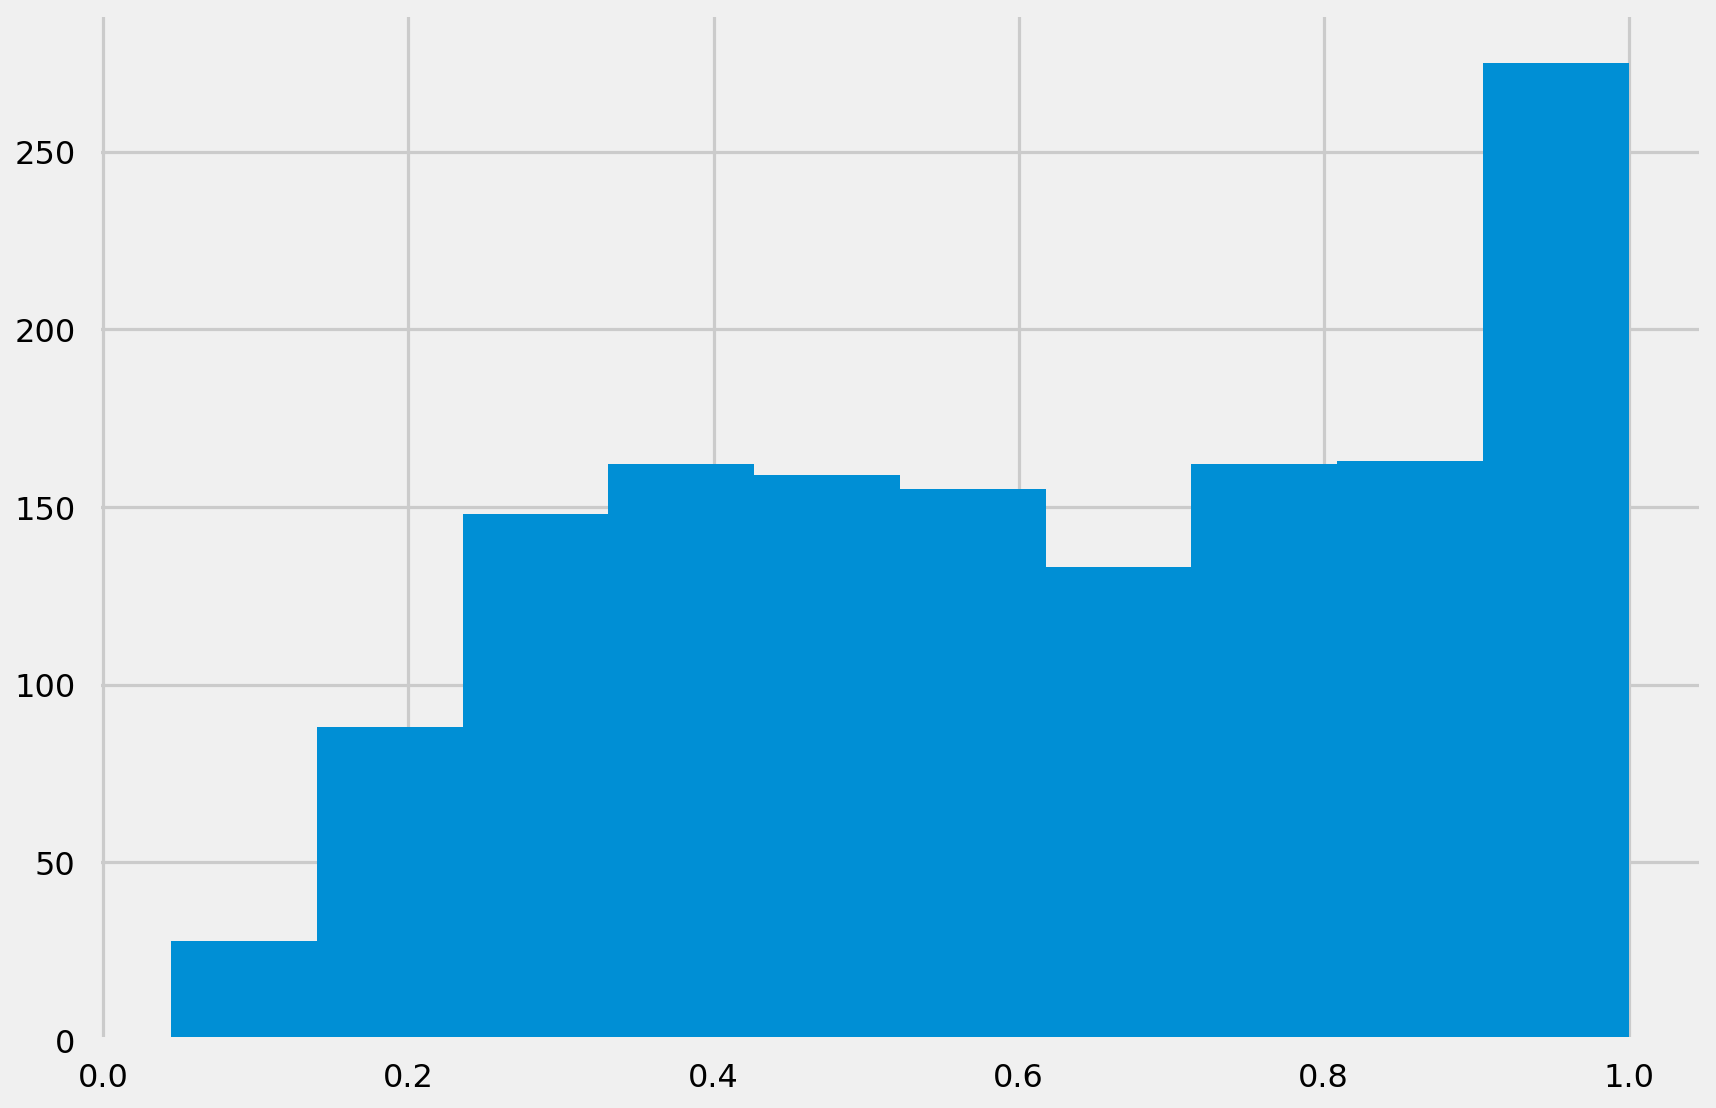

In [29]:
# Histogram of confidence scores for the p1 prediction
plt.hist(df.query('p1_dog == True')['p1_conf'])

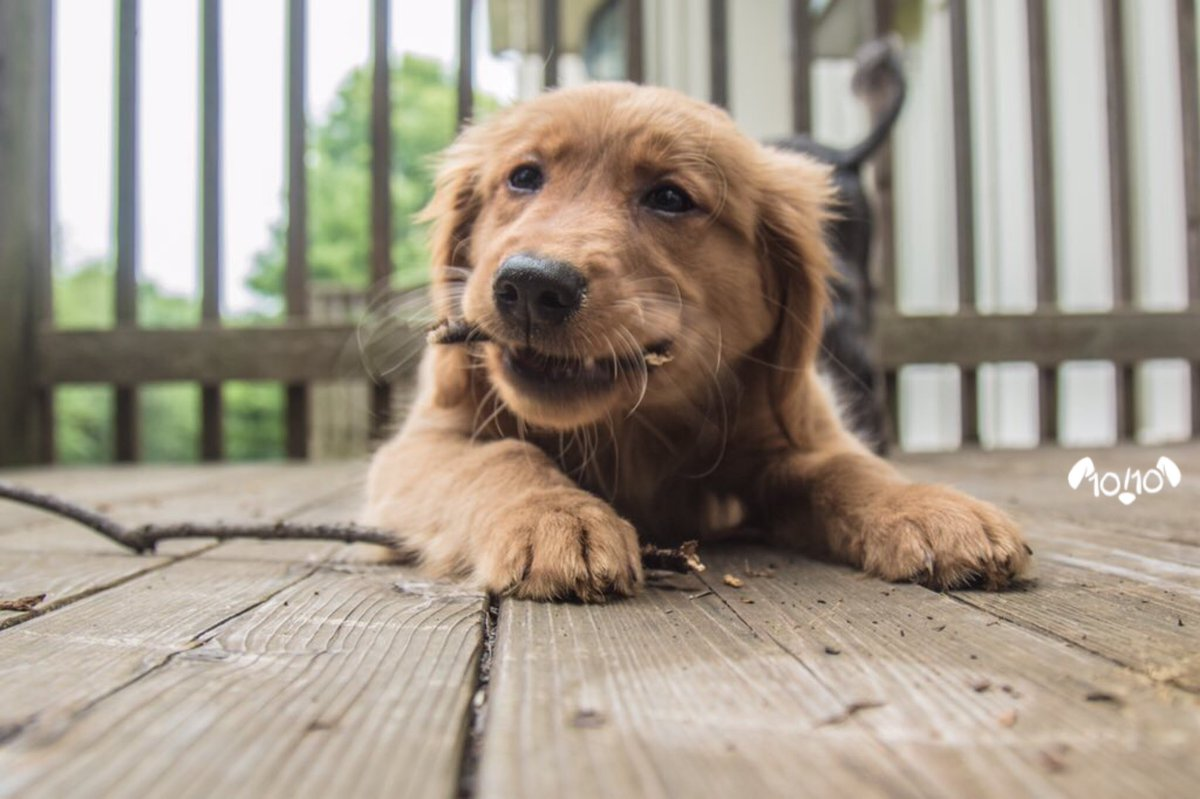

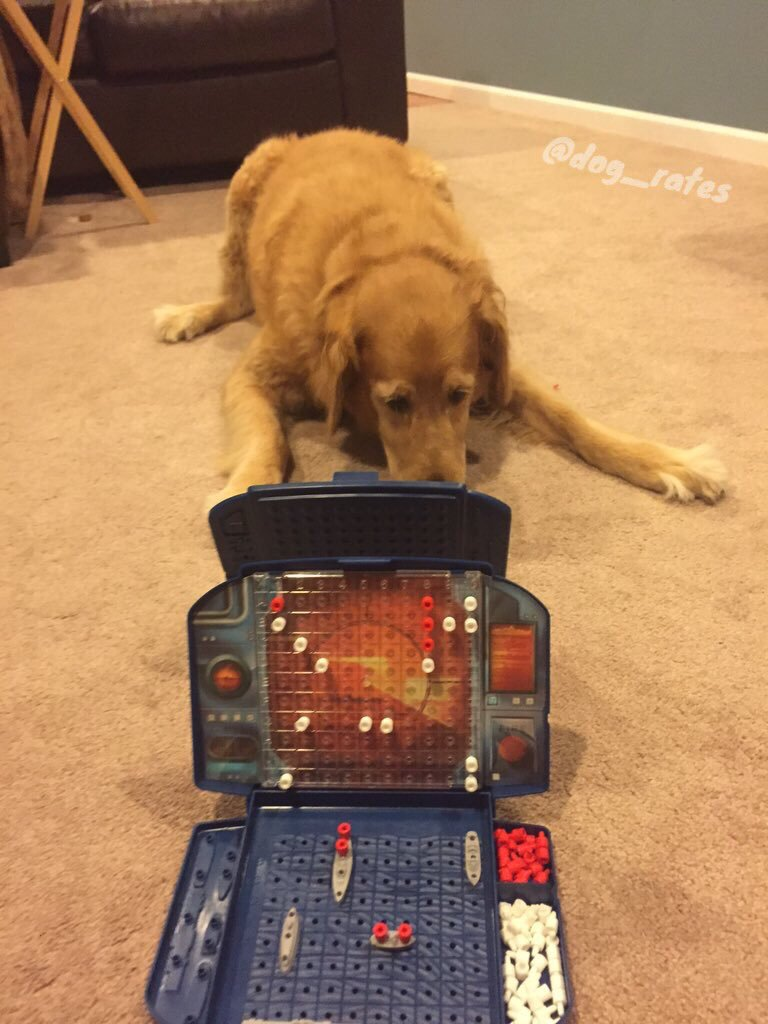

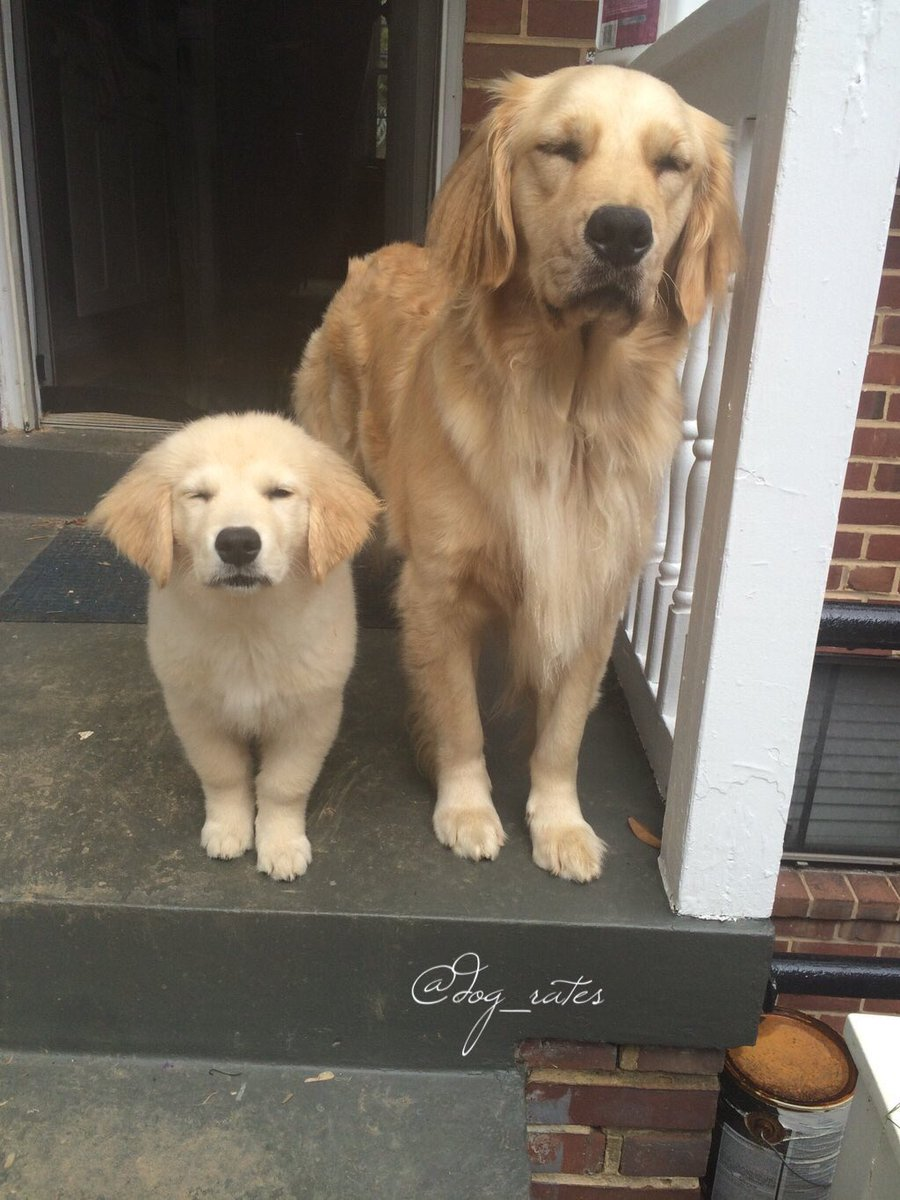

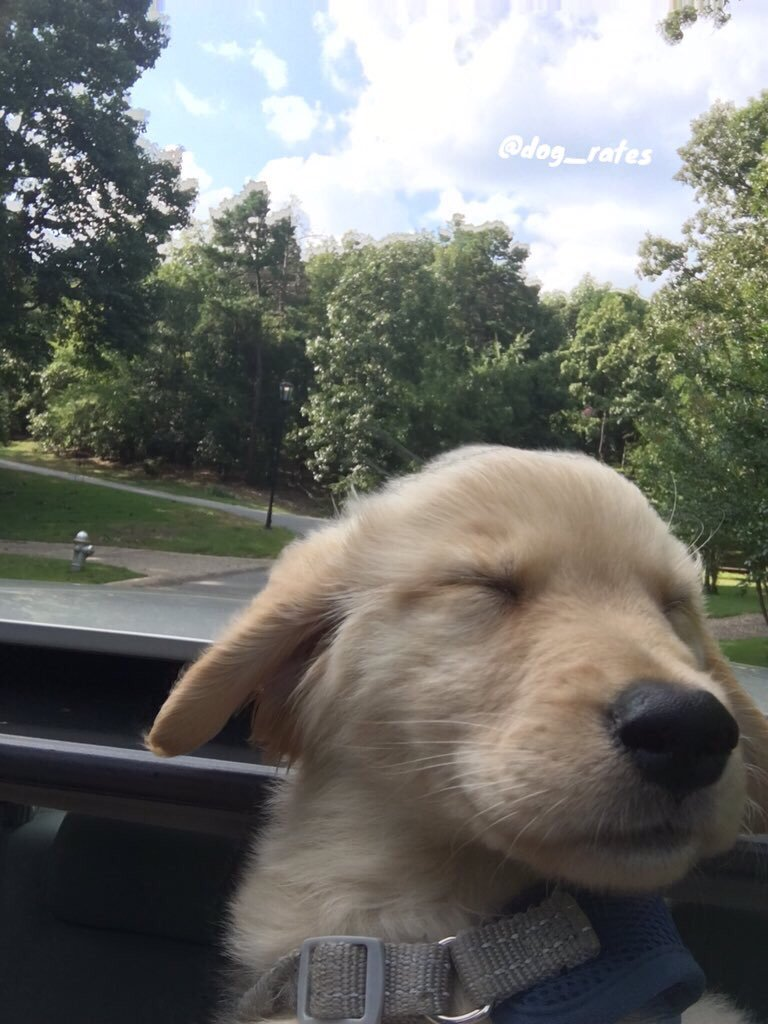

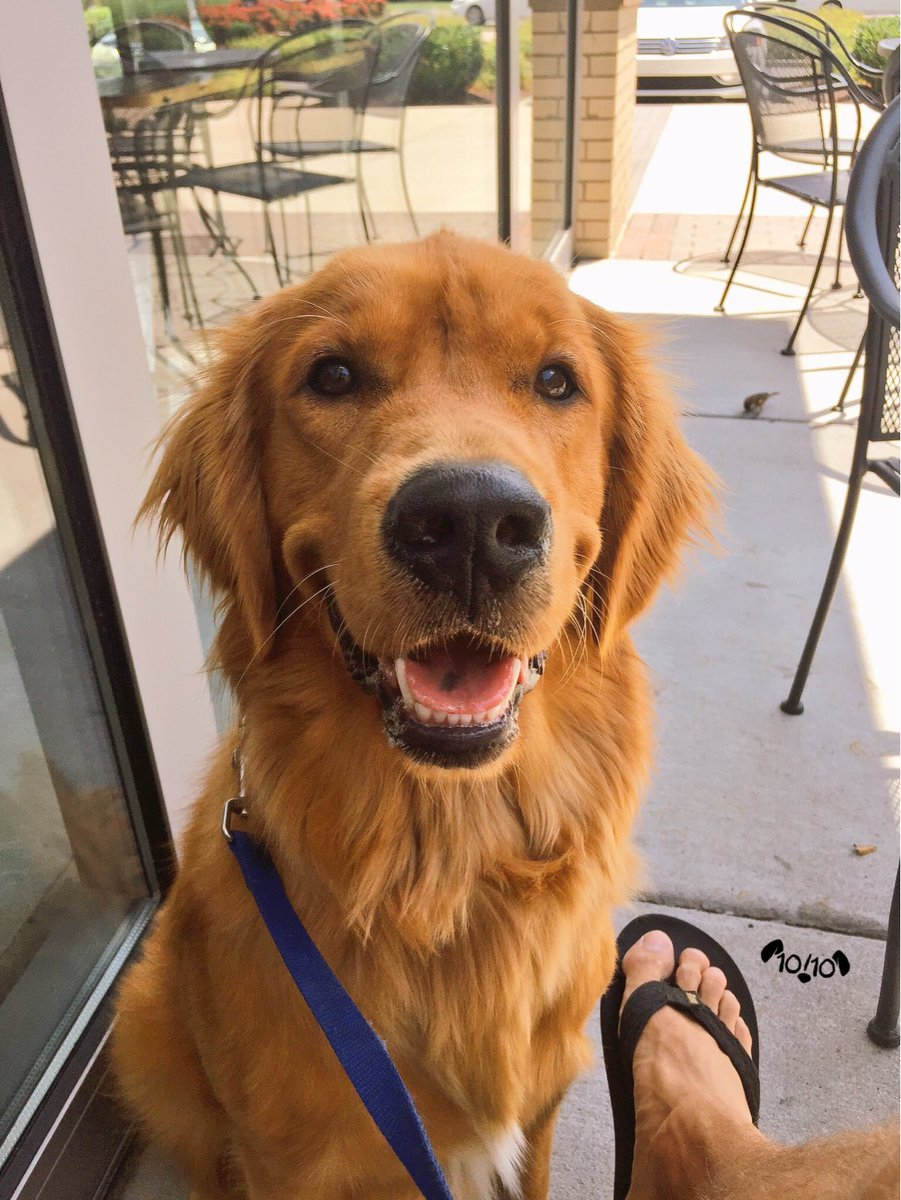

In [30]:
# Pick 10 random golden retrievers
images = df.query('p1 == "golden_retriever"').sample(n=5)

# Display the images
for i, j in images.iterrows():
    img = Image(url=j['jpg_url'], format='jpg', width=200, embed=True)
    display(img)

In [31]:
df.p1.value_counts().head(10)

golden_retriever      139
Labrador_retriever     93
Pembroke               88
Chihuahua              79
pug                    54
chow                   41
Samoyed                39
Pomeranian             38
toy_poodle             38
malamute               29
Name: p1, dtype: int64

## (TODO) Tidyness: Flatten JSON columns

## Save clean data

We're going to save a copy of the cleaned data frame to a CSV file.

In [32]:
df.to_csv('data/twitter_archive_master.csv')

## Analysis

 Provide **at least three (3) insights** and **one (1) visualization**.

### Question: Do certain dog breeds get higher ratings?

In [33]:
df['intercept'] = 1

In [34]:
lm_doggie = sm.OLS(df['rating'], df[doggie_types])
results_doggie = lm_doggie.fit()
results_doggie.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 rating   R-squared:                       0.010
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     5.137
Date:                Wed, 22 May 2019   Prob (F-statistic):           0.000406
Time:                        16:07:29   Log-Likelihood:                -5685.7
No. Observations:                1990   AIC:                         1.138e+04
Df Residuals:                    1986   BIC:                         1.140e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
doggo          1.0232      0.492      2.079      0.038       0.058       1.988
floofer        1.0596      1.492      0.710      0.478      -1.867       3.986
pupper         1.0292      0.290      3.544      0.000       0.460       1.599
puppo          1.1599      0.880      1.319      0.187      -0.565       2.885
==============================================================================
Omnibus:                     5909.384   Durbin-Watson:                   1.880
Prob(Omnibus):                  0.000   Jarque-Bera (JB):        253265224.076
Skew:                          40.906   Prob(JB):                         0.00
Kurtosis:                    1748.784   Cond. No.                         5.16
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [35]:
for dtype in doggie_types:
    q = dtype + ' == 1'
    print(dtype, ": \n", df.query(q)['rating'].describe(), "\n")

doggo : 
 count    74.000000
mean      1.178378
std       0.160709
min       0.500000
25%       1.100000
50%       1.200000
75%       1.300000
max       1.400000
Name: rating, dtype: float64 

floofer : 
 count    8.000000
mean     1.187500
std      0.112599
min      1.000000
25%      1.100000
50%      1.200000
75%      1.300000
max      1.300000
Name: rating, dtype: float64 

pupper : 
 count    212.000000
mean       1.072642
std        0.208371
min        0.300000
25%        1.000000
50%        1.100000
75%        1.200000
max        2.700000
Name: rating, dtype: float64 

puppo : 
 count    23.000000
mean      1.204348
std       0.129609
min       0.900000
25%       1.150000
50%       1.200000
75%       1.300000
max       1.400000
Name: rating, dtype: float64 



In [36]:
doggo = df.query('doggo == 1').assign(dtype = 'doggo')
floofer = df.query('floofer == 1').assign(dtype= 'floofer')
pupper = df.query('pupper == 1').assign(dtype= 'pupper')
puppo = df.query('puppo == 1').assign(dtype= 'puppo')

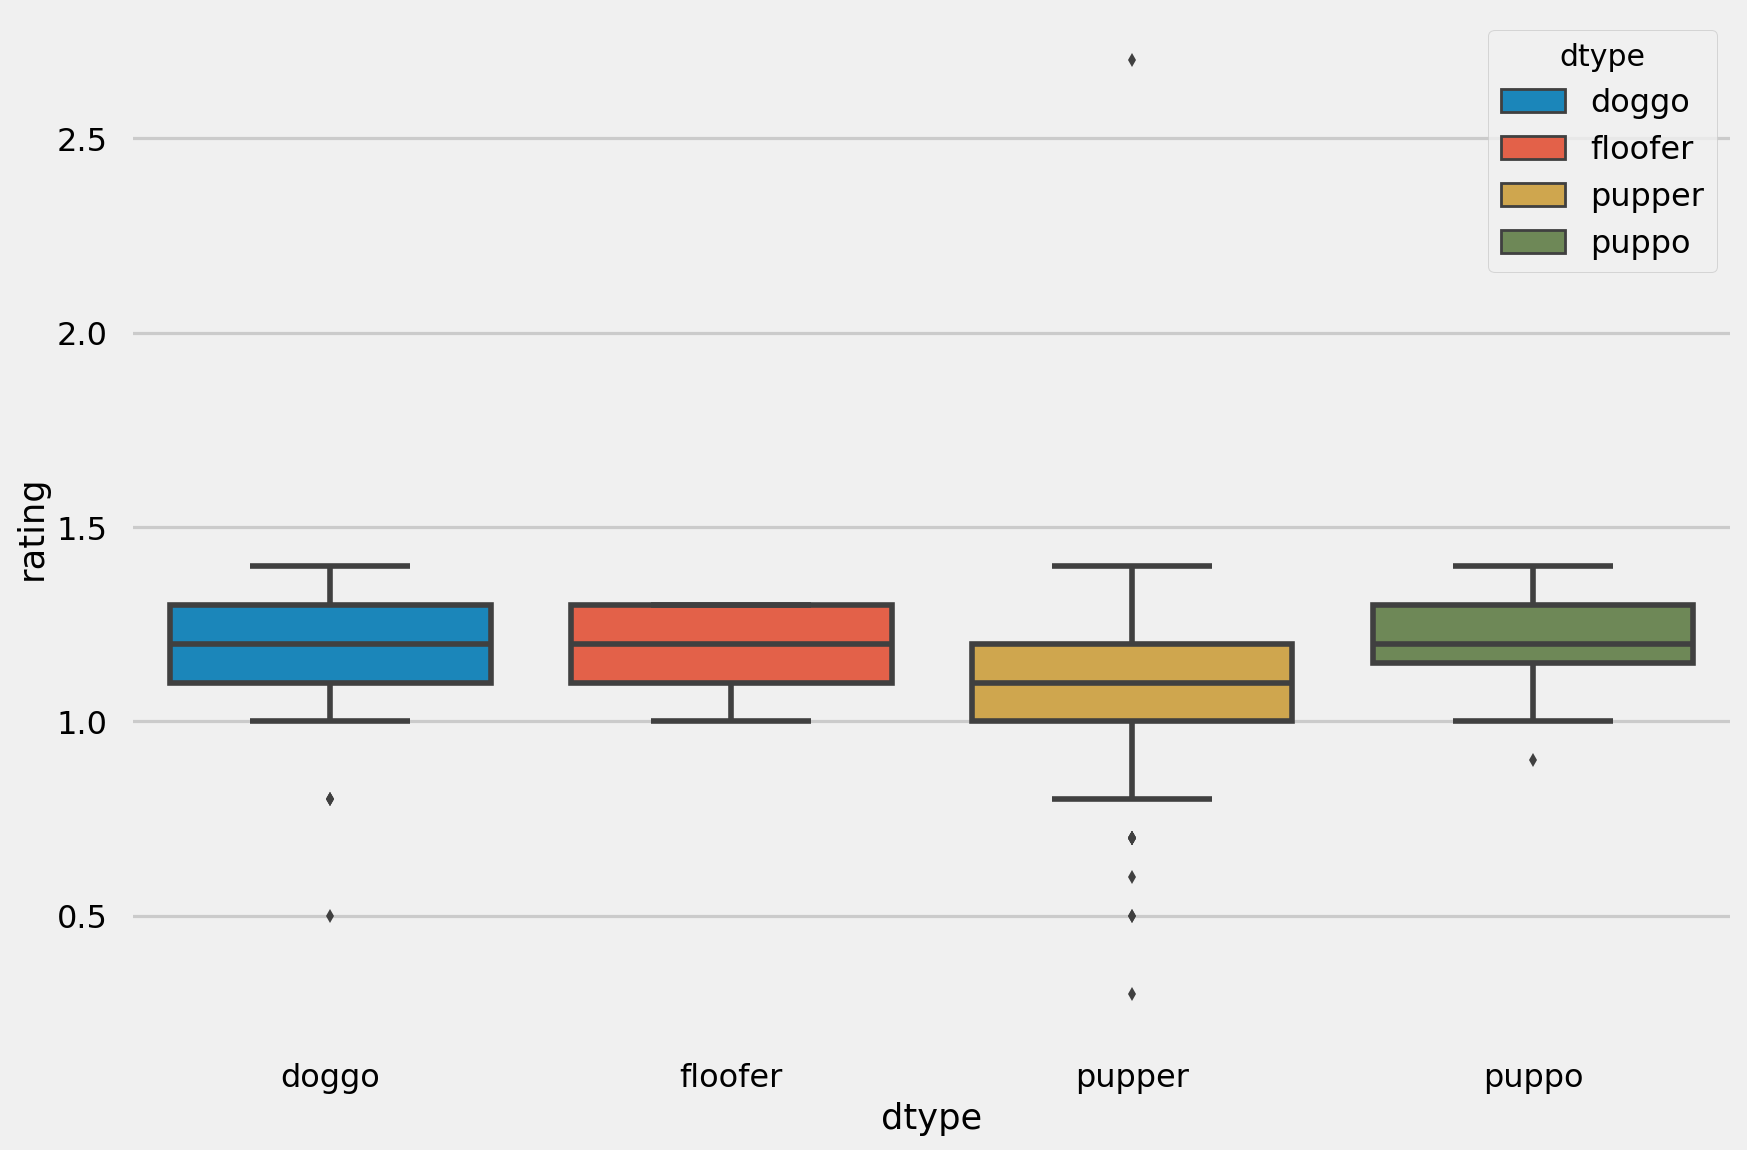

In [37]:
cdf = pd.concat([doggo, floofer, pupper, puppo])
ax = sns.boxplot(x="dtype", y="rating", hue="dtype", data=cdf, dodge=False)
plt.show()

In [38]:
# TODO - decide whether I need this
from flatten_json import flatten

data = df['extended_entities']
dict_flattened = (flatten(record, '.') for record in data)
df2 = pd.DataFrame(dict_flattened)
df2.dtypes

media.0.additional_media_info.monetizable      object
media.0.display_url                            object
media.0.expanded_url                           object
media.0.id                                      int64
media.0.id_str                                 object
media.0.indices.0                               int64
media.0.indices.1                               int64
media.0.media_url                              object
media.0.media_url_https                        object
media.0.sizes.large.h                           int64
media.0.sizes.large.resize                     object
media.0.sizes.large.w                           int64
media.0.sizes.medium.h                          int64
media.0.sizes.medium.resize                    object
media.0.sizes.medium.w                          int64
media.0.sizes.small.h                           int64
media.0.sizes.small.resize                     object
media.0.sizes.small.w                           int64
media.0.sizes.thumb.h       

In [39]:
# TODO - decide whether I need this
from flatten_json import flatten

data = df['entities']
dict_flattened = (flatten(record, '.') for record in data)
df2 = pd.DataFrame(dict_flattened)
df2.dtypes

hashtags                        object
hashtags.0.indices.0           float64
hashtags.0.indices.1           float64
hashtags.0.text                 object
hashtags.1.indices.0           float64
hashtags.1.indices.1           float64
hashtags.1.text                 object
media.0.display_url             object
media.0.expanded_url            object
media.0.id                       int64
media.0.id_str                  object
media.0.indices.0                int64
media.0.indices.1                int64
media.0.media_url               object
media.0.media_url_https         object
media.0.sizes.large.h            int64
media.0.sizes.large.resize      object
media.0.sizes.large.w            int64
media.0.sizes.medium.h           int64
media.0.sizes.medium.resize     object
media.0.sizes.medium.w           int64
media.0.sizes.small.h            int64
media.0.sizes.small.resize      object
media.0.sizes.small.w            int64
media.0.sizes.thumb.h            int64
media.0.sizes.thumb.resiz

In [40]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1990 entries, 892420643555336193 to 666020888022790149
Data columns (total 38 columns):
timestamp                  1990 non-null datetime64[ns, UTC]
text                       1990 non-null object
expanded_urls              1990 non-null object
rating_numerator           1990 non-null int64
rating_denominator         1990 non-null int64
name                       1990 non-null object
doggo                      1990 non-null int64
floofer                    1990 non-null int64
pupper                     1990 non-null int64
puppo                      1990 non-null int64
jpg_url                    1990 non-null object
img_num                    1990 non-null int64
p1                         1990 non-null object
p1_conf                    1990 non-null float64
p1_dog                     1990 non-null bool
p2                         1990 non-null object
p2_conf                    1990 non-null float64
p2_dog                     1990 non-null

### Question: Do certain dog breeds get more favorites or retweets?

In [41]:
for dtype in doggie_types:
    q = dtype + ' == 1'
    print(dtype, ": \n", df.query(q)['favorite_count'].describe(), "\n")

doggo : 
 count        74.000000
mean      19269.013514
std       25376.625086
min        2446.000000
25%        7801.250000
50%       11332.500000
75%       19069.750000
max      162019.000000
Name: favorite_count, dtype: float64 

floofer : 
 count        8.00000
mean     12978.00000
std       9978.34103
min       2145.00000
25%       5216.25000
50%      11200.50000
75%      17740.75000
max      31480.00000
Name: favorite_count, dtype: float64 

pupper : 
 count       212.000000
mean       7162.103774
std       11266.811316
min         654.000000
25%        2304.750000
50%        3193.000000
75%        7672.750000
max      120363.000000
Name: favorite_count, dtype: float64 

puppo : 
 count        23.000000
mean      22547.391304
std       29103.554415
min        3073.000000
25%        6659.000000
50%       14653.000000
75%       20803.500000
max      138328.000000
Name: favorite_count, dtype: float64 



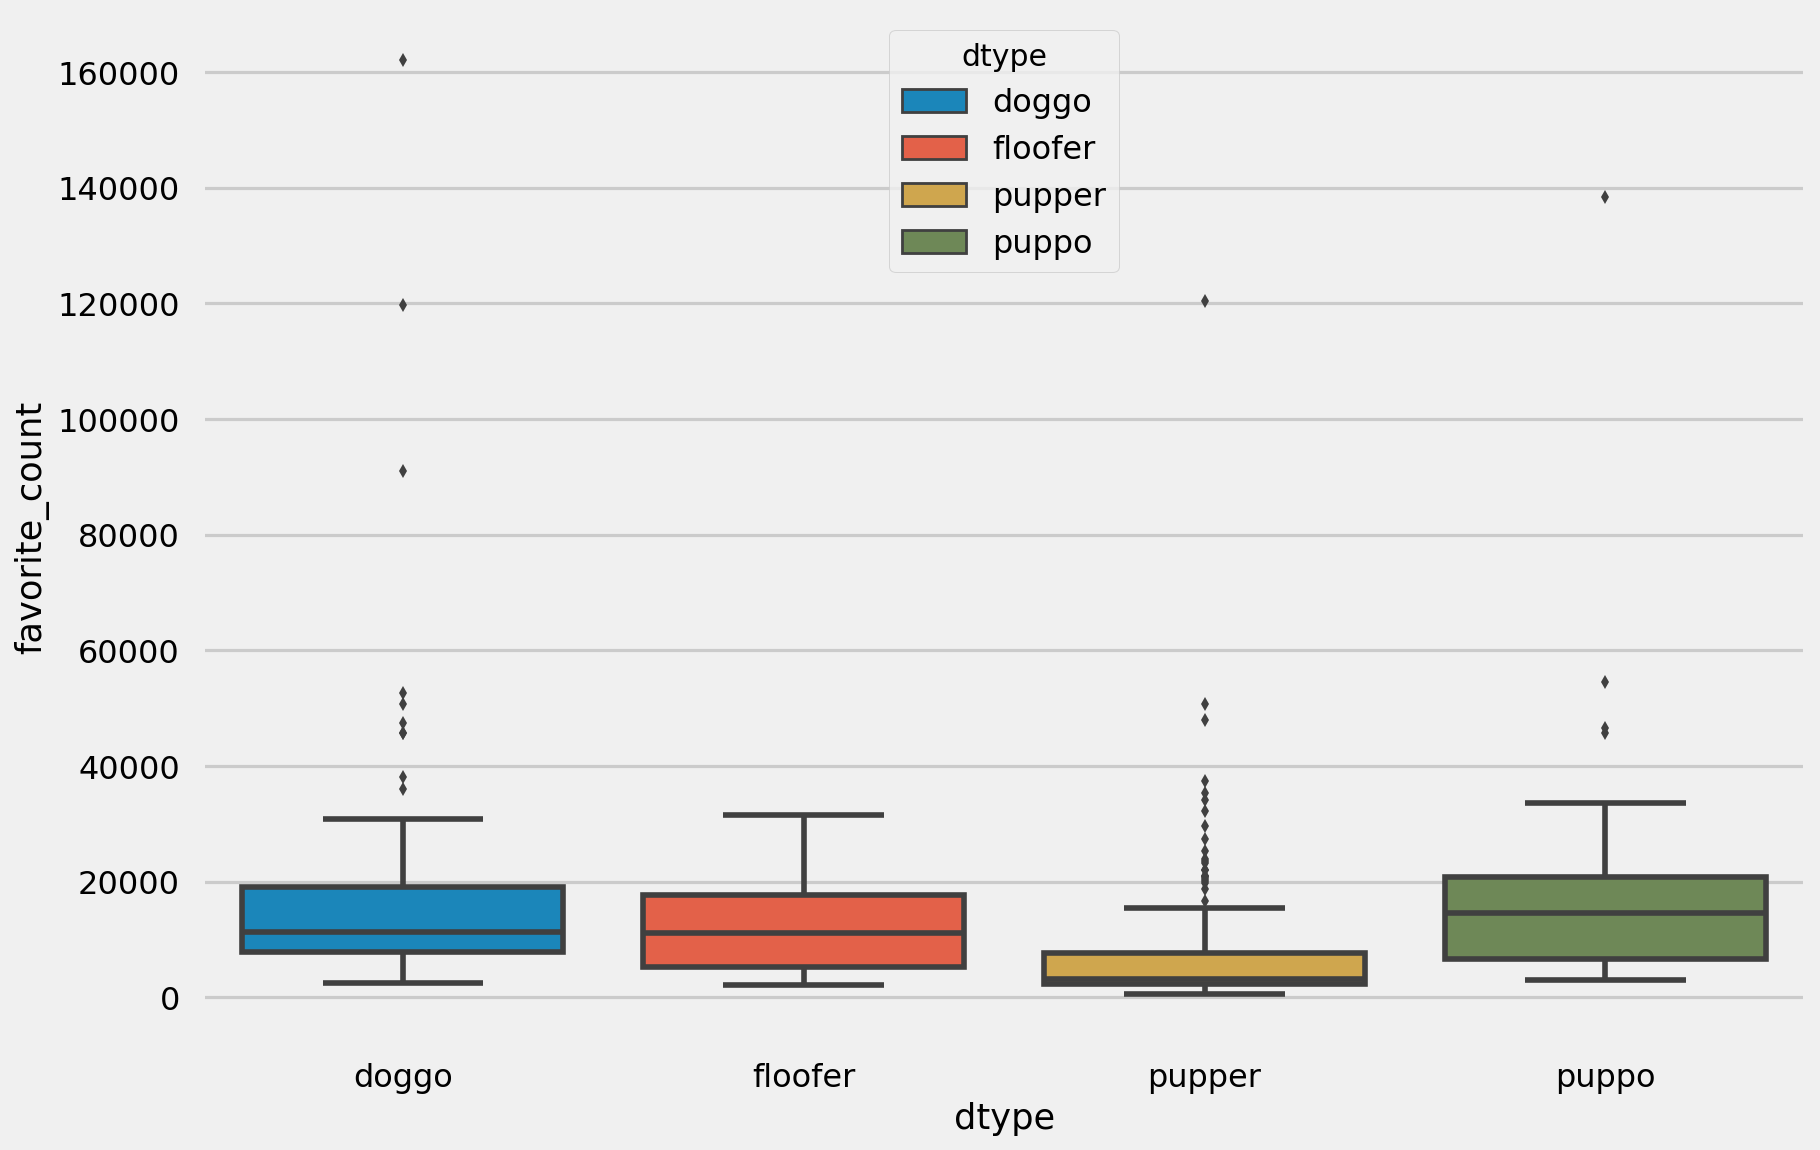

In [42]:
cdf = pd.concat([doggo, floofer, pupper, puppo])
ax = sns.boxplot(x="dtype", y="favorite_count", hue="dtype", data=cdf, dodge=False)
plt.show()

In [43]:
lm_doggie = sm.OLS(df['favorite_count'], df[doggie_types])
results_doggie = lm_doggie.fit()
results_doggie.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         favorite_count   R-squared:                       0.103
Model:                            OLS   Adj. R-squared:                  0.102
Method:                 Least Squares   F-statistic:                     57.24
Date:                Wed, 22 May 2019   Prob (F-statistic):           9.15e-46
Time:                        16:07:38   Log-Likelihood:                -21884.
No. Observations:                1990   AIC:                         4.378e+04
Df Residuals:                    1986   BIC:                         4.380e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
doggo       1.805e+04   1686.842     10.702      0.000    1.47e+04    2.14e+04
floofer     1.072e+04   5115.558      2.096      0.036     689.054    2.08e+04
pupper      6395.7376    995.468      6.425      0.000    4443.466    8348.010
puppo       2.176e+04   3015.320      7.217      0.000    1.58e+04    2.77e+04
==============================================================================
Omnibus:                     1631.682   Durbin-Watson:                   1.024
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            51983.603
Skew:                           3.673   Prob(JB):                         0.00
Kurtosis:                      26.937   Cond. No.                         5.16
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Question: Are retweets and favorites correlated?

Do tweets that get lots of retweets also likely to get lots of favorites?

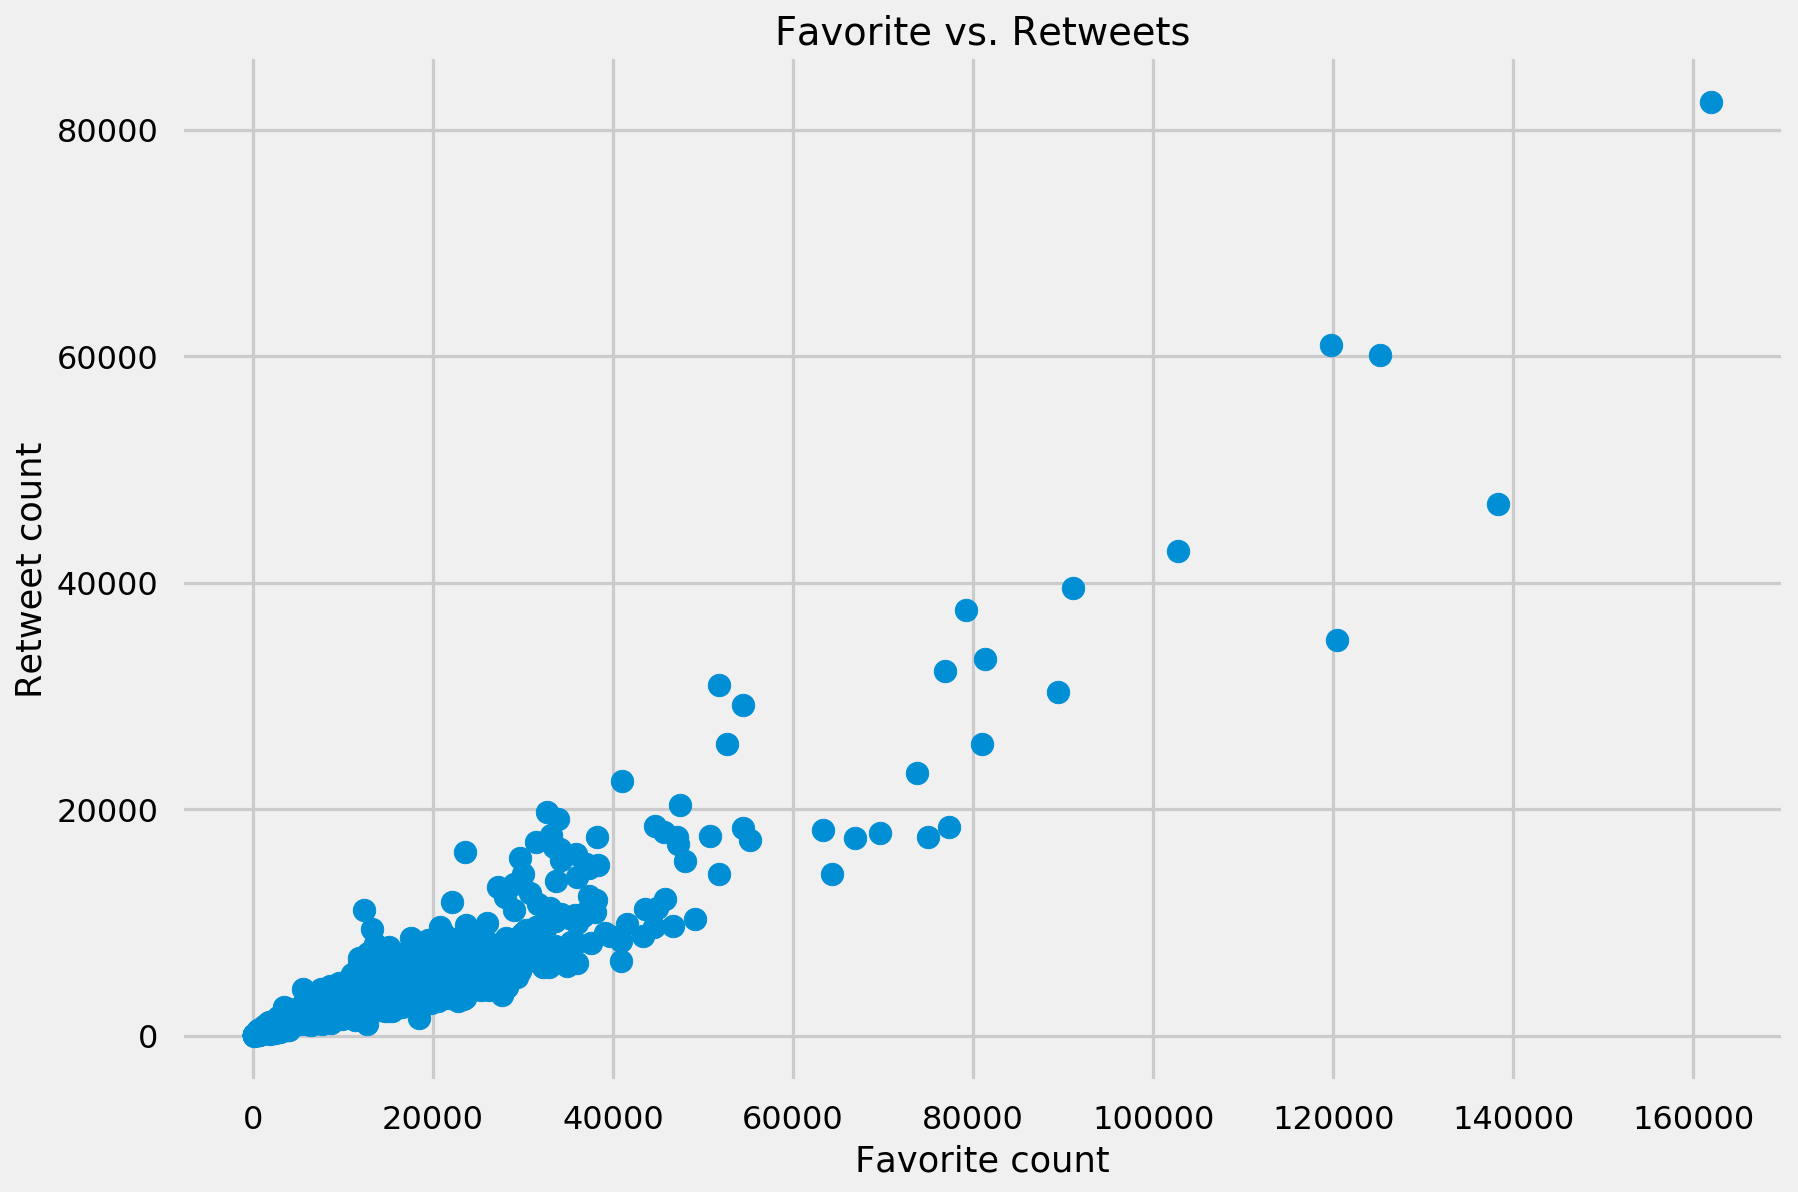

In [44]:
plt.scatter(df['favorite_count'], df['retweet_count'])
plt.title("Favorite vs. Retweets")
plt.xlabel("Favorite count")
plt.ylabel("Retweet count")
plt.show()

In [45]:
df['favorite_count'].corr(df['retweet_count'])

0.9295896613605447

Conclusion: Yes! Retweet and favorite count is strongly positively correlated (0.93).

In [46]:
df.query('retweet_count > 80000').index

Int64Index([744234799360020481], dtype='int64', name='tweet_id')

In [47]:
from IPython.core.display import HTML

HTML('<img src="' + df.loc[744234799360020481].jpg_url + '"/><h3>' + df.loc[744234799360020481].text + '</h3>')